In [221]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

## Import the dataset

[Google Local Data (2021). Alaska 10-core (521,515 reviews)](https://datarepo.eng.ucsd.edu/mcauley_group/gdrive/googlelocal/)

This Dataset contains review information on Google map (ratings, text, images, etc.), business metadata (address, geographical info, descriptions, category information, price, open hours, and MISC info), and links (relative businesses) up to Sep 2021 in the United States.

These data have been reduced to extract the k-core, such that each of the remaining users and items have k reviews each.

<ul>
<li>user_id - ID of the reviewer
<li>name - name of the reviwer
<li>time - time of the review (unix time)
<li>rating - rating of the business
<li>text - text of the review
<li>pics - pictures of the review
<li>resp - business response to the review including unix time and text of the response
<li>gmap_id - ID of the business
</ul>

Metadata:
<ul>
<li>name - name of the business
<li>address - address of the business
<li>gmap_id - ID of the business
<li>description - description of the business
<li>latitude - latitude of the business
<li>longitude - longitude of the business
<li>category - category of the business
<li>avg_rating - average rating of the business
<li>num_of_reviews - number of reviews
<li>price - price of the business
<li>hours - open hours
<li>MISC - MISC information
<li>state - the current status of the business (e.g., permanently closed)
<li>relative_results - relative businesses recommended by Google
<li>url - URL of the business
</ul>

Format is one-review-per-line in json.

Citation
1. UCTopic: Unsupervised Contrastive Learning for Phrase Representations and Topic Mining
Jiacheng Li, Jingbo Shang, Julian McAuley
Annual Meeting of the Association for Computational Linguistics (ACL), 2022
[pdf](https://aclanthology.org/2022.acl-long.426.pdf)

2. Personalized Showcases: Generating Multi-Modal Explanations for Recommendations
An Yan, Zhankui He, Jiacheng Li, Tianyang Zhang, Julian Mcauley
The 46th International ACM SIGIR Conference on Research and Development in Information Retrieval (SIGIR), 2023
[pdf](https://arxiv.org/pdf/2207.00422.pdf)

In [204]:
df_reviews = pd.read_json('./data/review-Alaska_10.json.gz', lines=True, compression='gzip')

In [205]:
df_reviews.head(3)

,user_id,name,time,rating,text,pics,resp,gmap_id
0,1.091298e+20,Nicki Gore,1566331951619,5,We always stay here when in Valdez for silver ...,None,None,0x56b646ed2220b77f:0xd8975e316de80952
1,1.132409e+20,Allen Ratliff,1504917982385,5,Great campground for the price. Nice hot unlim...,None,None,0x56b646ed2220b77f:0xd8975e316de80952
2,1.130448e+20,Jonathan Tringali,1474765901185,4,We tent camped here for 2 nights while explori...,None,None,0x56b646ed2220b77f:0xd8975e316de80952


In [206]:
df_meta = pd.read_json('./data/meta-Alaska.json.gz', lines=True, compression='gzip')

In [207]:
df_meta.head(3)

,name,address,gmap_id,description,latitude,longitude,category,avg_rating,num_of_reviews,price,hours,MISC,state,relative_results,url
0,Bear Creek Cabins & RV Park,"Bear Creek Cabins & RV Park, 3181 Richardson H...",0x56b646ed2220b77f:0xd8975e316de80952,None,61.100644,-146.214552,"[RV park, Cabin rental agency, Campground]",4.5,18,None,None,None,None,"[0x56b6445fd9f9e387:0x6dd3d374ef56431a, 0x56b6...",https://www.google.com/maps/place//data=!4m2!3...
1,Anchorage Market,"Anchorage Market, 88th Ave, Anchorage, AK 99515",0x56c8992b5dee7225:0x9f7f4bf151868cf7,None,61.141435,-149.868482,[Farmers' market],4.2,18,None,"[[Thursday, Closed], [Friday, 10AM–5PM], [Satu...","{'Service options': ['In-store shopping'], 'Ac...",Closed ⋅ Opens 10AM Fri,None,https://www.google.com/maps/place//data=!4m2!3...
2,Happy Camper RV,"Happy Camper RV, 1151 N Shenandoah Dr # 4, Pal...",0x56c8e0455225be87:0xf24828df75e2f8ae,None,61.591855,-149.290657,[RV repair shop],4.4,28,None,None,{'Accessibility': ['Wheelchair accessible entr...,None,"[0x56c8e104d9929a1d:0x2070ad63defadbf, 0x56c91...",https://www.google.com/maps/place//data=!4m2!3...


In [208]:
df_meta['category'].value_counts()[:20]

category
[Lake]                        167
[Restaurant]                  163
[River]                       162
[Coffee shop]                 150
[Gas station]                 139
[Campground]                  109
[Cafe]                        106
[Bar]                          94
[Hiking area]                  91
[Hotel]                        87
[Park]                         83
[Grocery store]                81
[Cannabis store]               78
[Tourist attraction]           76
[Gift shop]                    76
[Park, Tourist attraction]     70
[Church]                       69
[Bay]                          65
[Auto repair shop]             62
[Non-profit organization]      61
Name: count, dtype: int64

## Preprocessing

### Remove unnecessary features

In [209]:
# We'll be using only gmap_id, address, avg_rating, num_of_reviews as business features.
feature_columns = ['gmap_id', 'address', 'category', 'avg_rating', 'num_of_reviews']

df_meta = df_meta.loc[:, feature_columns]

In [210]:
# We need only user_id, rating and gmap_id.
feature_columns = ['user_id', 'gmap_id', 'rating']

df_reviews = df_reviews[feature_columns]

### Count of businesses by city

In [211]:
def get_city(address):
    if not address:
        return None
    
    address_fields = address.split(', ')

    if len(address_fields) == 1:
        return address_fields[0]
    
    return address_fields[-2]

df_meta['address'].apply(lambda address: get_city(address)).value_counts()[:10]

address
Anchorage      4228
Fairbanks      1285
Wasilla         863
Juneau          642
Palmer          428
Soldotna        344
Ketchikan       323
Homer           307
Eagle River     270
Kenai           240
Name: count, dtype: int64

In [212]:
# City we want to analize
city = 'Fairbanks'

### Get businesses from the city

In [213]:
def is_address_from_city(address, city):
    if not address:
        return False
    
    address_fields = address.split(', ')

    if len(address_fields) == 1:
        return address_fields[0] == city
    
    if address_fields[-2] == city:
        return True
    return False

city_mask = df_meta['address'].apply(lambda address: is_address_from_city(address, city))
businesses_from_city = df_meta[city_mask].reset_index(drop=True)

In [214]:
businesses_from_city['category'].apply(lambda x: x[0] if x else None).value_counts()

category
Restaurant                24
Gas station               23
Coffee shop               21
Park                      20
Auto repair shop          19
                          ..
Aviation                   1
Aircraft supply store      1
Print shop                 1
Tannery                    1
Fine dining restaurant     1
Name: count, Length: 519, dtype: int64

### Get users from the city

In [215]:
def user_is_good_for_city(user_id, city, threshold):
    global businesses_from_city, df_reviews

    user_reviews = df_reviews[df_reviews['user_id'] == user_id]
    reviews_count = user_reviews['gmap_id'].isin(businesses_from_city['gmap_id']).sum()

    return reviews_count >= threshold

threshold = 10
user_ids = pd.Series(df_reviews['user_id'].unique())
user_mask = user_ids.apply(lambda user_id: user_is_good_for_city(user_id, city, threshold))

users_from_city = user_ids[user_mask].reset_index(drop=True)
print(f'{len(users_from_city)=}')

len(users_from_city)=2382


### Delete reviews outside the target city

In [216]:
business_mask = df_reviews['gmap_id'].isin(businesses_from_city['gmap_id'])
user_mask = df_reviews['user_id'].isin(users_from_city)

df_reviews = df_reviews[business_mask & user_mask]

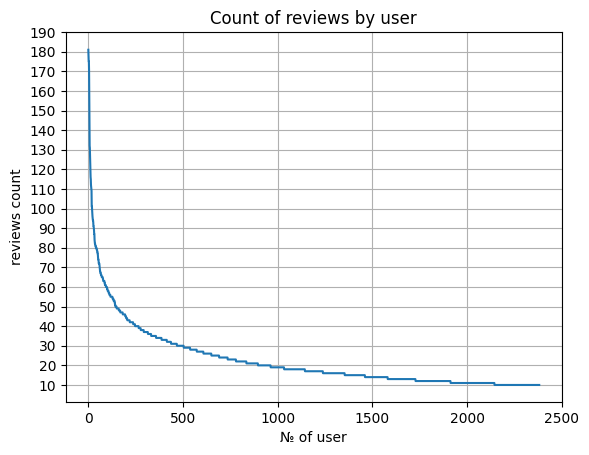

In [244]:
count_of_reviews_by_user = df_reviews.groupby('user_id').count()['gmap_id']\
    .sort_values(ascending=False).values

plt.title('Count of reviews by user')
plt.plot(count_of_reviews_by_user)
plt.ylabel('reviews count')
plt.xlabel('№ of user')
plt.yticks(np.arange(threshold, count_of_reviews_by_user[0]+10, 10))
plt.grid()